In [1]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/srv/conda/lib/python3.6/site-packages/dask_kubernetes/config.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.13.19:35137 Dashboard: /user/0000-0001-7783-5629/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import xscale 
import Wavenum_freq_spec_func as wfs
import time

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
from matplotlib.colors import LogNorm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [5]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')

gcsmapgrid=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/grid',gcs=fs,check=False,create=False)
dsgrid=xr.open_zarr(gcsmapgrid)


In [6]:

gcsmap=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/U',gcs=fs,check=False,create=False)
dsu=xr.open_zarr(gcsmap)

In [7]:

gcsmap=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/V',gcs=fs,check=False,create=False)
dsv=xr.open_zarr(gcsmap)

In [8]:
%%time
lat=dsgrid.sel(face=2)['YC']
lon=dsgrid.sel(face=2)['XC']


CPU times: user 17.8 ms, sys: 1.95 ms, total: 19.8 ms
Wall time: 18.9 ms


In [9]:
latmin = 40.0; latmax = 45.0;
lonmin = -40.0; lonmax = -35.0;


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [10]:
%%time
latbox=lat.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)
lonbox=lon.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)

CPU times: user 11.6 s, sys: 1.4 s, total: 13 s
Wall time: 1min 9s


In [11]:
%%time
u_JFM=dsu.sel(face=2,time=slice('2012-01-01','2012-03-31'))['U']
v_JFM=dsv.sel(face=2,time=slice('2012-01-01','2012-03-31'))['V']

u_JFM_i=u_JFM.rename({'i_g':'i'})
v_JFM_j=v_JFM.rename({'j_g':'j'})

u_JFM_box=u_JFM_i.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)
v_JFM_box=v_JFM_j.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)

# - remove NaN
u_JFM = u_JFM_box.interpolate_na(dim='j')
v_JFM = v_JFM_box.interpolate_na(dim='j')

# - get dx and dy
dx_JFM,dy_JFM = wfs.get_dx_dy(u_JFM[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JFM = wfs.detrendn(u_JFM,axes=[0,1,2])
v_JFM = wfs.detrendn(v_JFM,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JFM = wfs.apply_window(u_JFM, u_JFM.dims, window_type='hanning')
v_JFM = wfs.apply_window(v_JFM, v_JFM.dims, window_type='hanning')

# - get derivatives
derivatives_JFM = wfs.velocity_derivatives(u_JFM, v_JFM, xdim='i', ydim='j', dx={'i': dx_JFM, 'j': dy_JFM})
dudx_JFM = derivatives_JFM['u_x']; dudy_JFM = derivatives_JFM['u_y']
dvdx_JFM = derivatives_JFM['v_x']; dvdy_JFM = derivatives_JFM['v_y']

# - compute terms
phi1_JFM = u_JFM*dudx_JFM + v_JFM*dudy_JFM
phi2_JFM = u_JFM*dvdx_JFM + v_JFM*dvdy_JFM

u_JFMhat = xfft.fft(u_JFM, dim=('time', 'i', 'j'), dx={'i': dx_JFM, 'j': dx_JFM}, sym=True)
v_JFMhat = xfft.fft(v_JFM, dim=('time', 'i', 'j'), dx={'i': dx_JFM, 'j': dx_JFM}, sym=True)

phi1_JFM_hat = xfft.fft(phi1_JFM, dim=('time', 'i', 'j'), dx={'i': dx_JFM, 'j': dx_JFM}, sym=True)
phi2_JFM_hat = xfft.fft(phi2_JFM, dim=('time', 'i', 'j'), dx={'i': dx_JFM, 'j': dx_JFM}, sym=True)

tm1_JFM = (u_JFMhat.conj())*phi1_JFM_hat
tm2_JFM = (v_JFMhat.conj())*phi2_JFM_hat

# - computer transfer
Nk_JFM,Nj_JFM,Ni_JFM = u_JFM.shape
transfer_2D_JFM = -1.0*(tm1_JFM + tm2_JFM)/np.square(Ni_JFM*Nj_JFM)
transfer_term_JFM = transfer_2D_JFM.real

#... Get frequency and wavenumber ... 
print('Get frequency and wavenumber')
ffrequency_JFM = u_JFMhat.f_time
kx_JFM = u_JFMhat.f_i
ky_JFM = u_JFMhat.f_j

#... Get istropic wavenumber ... 
print('Get istropic wavenumber')
wavenumber_JFM,kradial_JFM = wfs.get_wavnum_kradial(kx_JFM,ky_JFM)

#... Get numpy array ... 
print('Get numpy array')
var_psd_np_JFM = transfer_term_JFM.values

#... Get 2D frequency-wavenumber field ... 
print('Get transfer')
transfer_JFM = wfs.get_f_k_in_2D(kradial_JFM,wavenumber_JFM,var_psd_np_JFM) 

print('Get flux')
flux_JFM = wfs.get_flux_in_1D(kradial_JFM,wavenumber_JFM,var_psd_np_JFM)

# Save to Netscdf file
# - build dataarray
print('Save to Netscdf file')
transfer_JFM_da = xr.DataArray(transfer_JFM,dims=['frequency','wavenumber'],name="transfer",coords=[ffrequency_JFM ,wavenumber_JFM])
flux_JFM_da = xr.DataArray(flux_JFM,dims=['frequency','wavenumber'],name="flux",coords=[ffrequency_JFM,wavenumber_JFM])
transfer_JFM_da.attrs['Name'] = 'KE_Transfer_Flux_JFM_w_k_from_1h_llc4320.nc'

transfer_JFM_da.to_dataset().to_netcdf(path='KE_Transfer_Flux_JFM_w_k_from_1h_llc4320.nc',mode='w',engine='scipy')
flux_JFM_da.to_dataset().to_netcdf(path='KE_Transfer_Flux_JFM_w_k_from_1h_llc4320.nc',mode='a',engine='scipy')


/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


Detrend data in all dimension
Apply hanning windowing
Get frequency and wavenumber
Get istropic wavenumber
Get numpy array
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
CPU times: user 17min 30s, sys: 3min 7s, total: 20min 37s
Wall time: 34min 33s


In [12]:
%%time
u_JAS=dsu.sel(face=2,time=slice('2012-06-01','2012-09-23'))['U']
v_JAS=dsv.sel(face=2,time=slice('2012-06-01','2012-09-23'))['V']

u_JAS_i=u_JAS.rename({'i_g':'i'})
v_JAS_j=v_JAS.rename({'j_g':'j'})

u_JAS_box=u_JAS_i.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)
v_JAS_box=v_JAS_j.where((lonmin<lon) & (lon<lonmax) & (latmin<lat) & (lat<latmax),drop=True)

# - remove NaN
u_JAS = u_JAS_box.interpolate_na(dim='j')
v_JAS = v_JAS_box.interpolate_na(dim='j')

# - get dx and dy
dx_JAS,dy_JAS = wfs.get_dx_dy(u_JAS[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JAS = wfs.detrendn(u_JAS,axes=[0,1,2])
v_JAS = wfs.detrendn(v_JAS,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JAS = wfs.apply_window(u_JAS, u_JAS.dims, window_type='hanning')
v_JAS = wfs.apply_window(v_JAS, v_JAS.dims, window_type='hanning')

# - get derivatives
derivatives_JAS = wfs.velocity_derivatives(u_JAS, v_JAS, xdim='i', ydim='j', dx={'i': dx_JAS, 'j': dy_JAS})
dudx_JAS = derivatives_JAS['u_x']; dudy_JAS = derivatives_JAS['u_y']
dvdx_JAS = derivatives_JAS['v_x']; dvdy_JAS = derivatives_JAS['v_y']

# - compute terms
phi1_JAS = u_JAS*dudx_JAS + v_JAS*dudy_JAS
phi2_JAS = u_JAS*dvdx_JAS + v_JAS*dvdy_JAS

u_JAShat = xfft.fft(u_JAS, dim=('time', 'i', 'j'), dx={'i': dx_JAS, 'j': dx_JAS}, sym=True)
v_JAShat = xfft.fft(v_JAS, dim=('time', 'i', 'j'), dx={'i': dx_JAS, 'j': dx_JAS}, sym=True)

phi1_JAS_hat = xfft.fft(phi1_JAS, dim=('time', 'i', 'j'), dx={'i': dx_JAS, 'j': dx_JAS}, sym=True)
phi2_JAS_hat = xfft.fft(phi2_JAS, dim=('time', 'i', 'j'), dx={'i': dx_JAS, 'j': dx_JAS}, sym=True)

tm1_JAS = (u_JAShat.conj())*phi1_JAS_hat
tm2_JAS = (v_JAShat.conj())*phi2_JAS_hat

# - computer transfer
Nk_JAS,Nj_JAS,Ni_JAS = u_JAS.shape
transfer_2D_JAS = -1.0*(tm1_JAS + tm2_JAS)/np.square(Ni_JAS*Nj_JAS)
transfer_term_JAS = transfer_2D_JAS.real

#... Get frequency and wavenumber ... 
print('Get frequency and wavenumber')
ffrequency_JAS = u_JAShat.f_time
kx_JAS = u_JAShat.f_i
ky_JAS = u_JAShat.f_j

#... Get istropic wavenumber ... 
print('Get istropic wavenumber')
wavenumber_JAS,kradial_JAS = wfs.get_wavnum_kradial(kx_JAS,ky_JAS)

#... Get numpy array ... 
print('Get numpy array')
var_psd_np_JAS = transfer_term_JAS.values

#... Get 2D frequency-wavenumber field ... 
print('Get transfer')
transfer_JAS = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,var_psd_np_JAS) 

print('Get flux')
flux_JAS = wfs.get_flux_in_1D(kradial_JAS,wavenumber_JAS,var_psd_np_JAS)


/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/srv/conda/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


Detrend data in all dimension
Apply hanning windowing
Get frequency and wavenumber
Get istropic wavenumber
Get numpy array
Get transfer
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
Get flux
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
CPU times: user 20min 23s, sys: 3min 26s, total: 23min 49s
Wall time: 42min 30s


In [21]:
# Save to Netscdf file
# - build dataarray
print('Save to Netscdf file')
transfer_JAS_da = xr.DataArray(transfer_JAS,dims=['frequency','wavenumber'],name="transfer",coords=[ffrequency_JAS ,wavenumber_JAS])
flux_JAS_da = xr.DataArray(flux_JAS,dims=['frequency','wavenumber'],name="flux",coords=[ffrequency_JAS,wavenumber_JAS])
transfer_JAS_da.attrs['Name'] = 'KE_Transfer_Flux_JAS_w_k_from_1h_llc4320.nc'

transfer_JAS_da.to_dataset().to_netcdf(path='KE_Transfer_Flux_JAS_w_k_from_1h_llc4320.nc',mode='w',engine='scipy')
flux_JAS_da.to_dataset().to_netcdf(path='KE_Transfer_Flux_JAS_w_k_from_1h_llc4320.nc',mode='a',engine='scipy')


Save to Netscdf file


In [23]:
#Open netcdf

ds_JFM=xr.open_dataset('KE_Transfer_Flux_JFM_w_k_from_1h_llc4320.nc')
ds_JAS=xr.open_dataset('KE_Transfer_Flux_JAS_w_k_from_1h_llc4320.nc')


In [24]:
ds_JFM

<xarray.Dataset>
Dimensions:     (frequency: 2184, wavenumber: 173)
Coordinates:
  * frequency   (frequency) float64 -0.0001389 -0.0001388 ... 0.0001388
  * wavenumber  (wavenumber) float64 0.001605 0.00321 0.004815 ... 0.2761 0.2777
Data variables:
    transfer    (frequency, wavenumber) float64 ...
    flux        (frequency, wavenumber) float64 ...

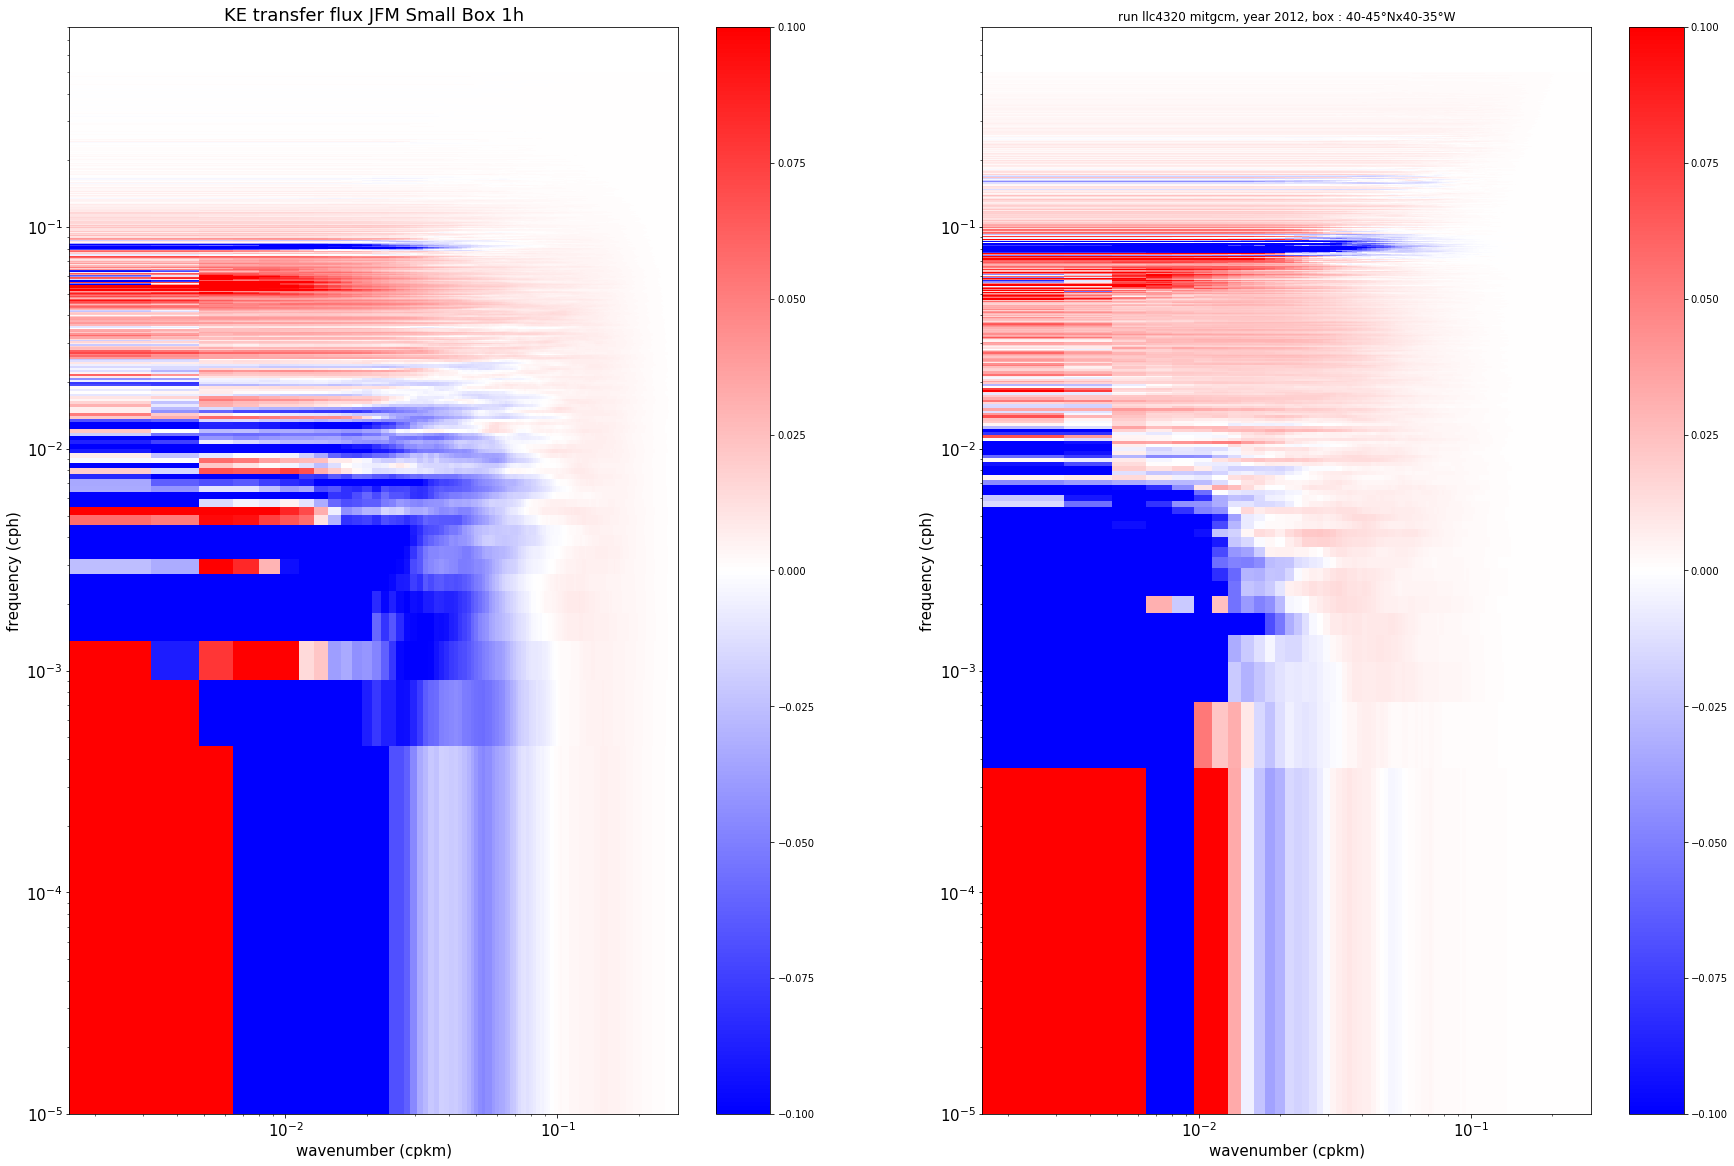

In [25]:
#Open netcdf

ds_JFM=xr.open_dataset('KE_Transfer_Flux_JFM_w_k_from_1h_llc4320.nc')
ds_JAS=xr.open_dataset('KE_Transfer_Flux_JAS_w_k_from_1h_llc4320.nc')

wavenumber_JFM=ds_JFM['wavenumber']
ffrequency_JFM=ds_JFM['frequency']
flux_JFM=ds_JFM['flux']

wavenumber_JAS=ds_JAS['wavenumber']
ffrequency_JAS=ds_JAS['frequency']
flux_JAS=ds_JAS['flux']

sec_to_hour = 3600.0

cmap = 'bwr'

fig=plt.figure(figsize=(30,20))

ax = plt.subplot(121)
plt.pcolormesh(wavenumber_JFM,sec_to_hour*ffrequency_JFM,10*flux_JFM,cmap=cmap,vmin=-0.1,vmax=0.1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JFM.min(),wavenumber_JFM.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE transfer flux JFM Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

ax = plt.subplot(122)
plt.pcolormesh(wavenumber_JAS,sec_to_hour*ffrequency_JAS,10*flux_JAS,cmap=cmap,vmin=-0.1,vmax=0.1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JAS.min(),wavenumber_JAS.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE transfer flux JAS Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

plt.title('run llc4320 mitgcm, year 2012, box : 40-45°Nx40-35°W')
plt.savefig('KE_transfer_flux_llc4320_JFM-JAS_smallbox.png')